In [3]:
!unzip PageSegData

Archive:  PageSegData.zip
   creating: PageSegData/
   creating: PageSegData/PageImg/
  inflating: PageSegData/PageImg/1.JPG  
  inflating: PageSegData/PageImg/10.JPG  
  inflating: PageSegData/PageImg/100.JPG  
  inflating: PageSegData/PageImg/101.JPG  
  inflating: PageSegData/PageImg/102.JPG  
  inflating: PageSegData/PageImg/103.JPG  
  inflating: PageSegData/PageImg/104.JPG  
  inflating: PageSegData/PageImg/105.JPG  
  inflating: PageSegData/PageImg/106.JPG  
  inflating: PageSegData/PageImg/107.JPG  
  inflating: PageSegData/PageImg/108.JPG  
  inflating: PageSegData/PageImg/109.JPG  
  inflating: PageSegData/PageImg/11.JPG  
  inflating: PageSegData/PageImg/110.JPG  
  inflating: PageSegData/PageImg/111.JPG  
  inflating: PageSegData/PageImg/112.JPG  
  inflating: PageSegData/PageImg/113.JPG  
  inflating: PageSegData/PageImg/114.JPG  
  inflating: PageSegData/PageImg/115.JPG  
  inflating: PageSegData/PageImg/116.JPG  
  inflating: PageSegData/PageImg/117.JPG  
  inflating: Pa

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Environment and load data

In [8]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Input, concatenate, UpSampling2D #, Activation,Conv2DTranspose,,Add,UpSampling2D,concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import random
import pandas as pd

# load data
image_list = os.listdir("/content/PageSegData/PageImg/")
image_list = [filename.split(".")[0] for filename in image_list]
print(image_list)
def visualize(img, seg_img):
    """
    Visualizes image
    """
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title('Image')
    plt.subplot(1,2,2)
    plt.imshow(seg_img,cmap='gray')
    plt.title('Segmented Image')
    plt.show()
    
def get_segmented_img(img, n_classes):
    """
    Loads in the segmented image and create suitable segmentation label.
    """
    seg_labels = np.zeros((512, 512, 1))
    img = cv2.resize(img, (512, 512))
    img = img[:,:,0]
    seg_labels[:,:,0] = (img != 0).astype(int)
    return seg_labels

def preprocess_img(img):
    img = cv2.resize(img, (512,512))
    return img

def batch_generator(filelist, n_classes, batch_size):
    while True:
        X=[]
        Y=[]
        for i in range(batch_size):
            fn = random.choice(filelist)
            img = cv2.imread(f"/content/PageSegData/PageImg/{fn}.JPG", 0)
            ret, img = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY_INV)
            img = cv2.resize(img, (512,512))
            img = np.expand_dims(img, axis = -1)
            img = img / 255

            seg = cv2.imread(f"/content/PageSegData/PageSeg/{fn}_mask.png", 1)
            seg = get_segmented_img(seg, n_classes)

            X.append(img)
            Y.append(seg)
        yield np.array(X), np.array(Y)


['27', '273', '250', '107', '210', '8', '168', '138', '56', '196', '197', '128', '25', '135', '278', '252', '194', '65', '79', '262', '120', '172', '81', '200', '100', '134', '24', '80', '131', '241', '139', '288', '287', '59', '234', '248', '33', '203', '57', '199', '300', '223', '71', '291', '166', '208', '289', '145', '217', '265', '298', '202', '76', '264', '55', '69', '40', '83', '284', '108', '125', '214', '230', '242', '220', '43', '148', '255', '293', '232', '99', '187', '124', '296', '95', '222', '98', '73', '66', '258', '60', '272', '167', '240', '123', '285', '239', '2', '198', '292', '253', '34', '195', '37', '218', '50', '74', '126', '3', '16', '162', '151', '63', '30', '52', '201', '64', '62', '161', '22', '276', '23', '118', '122', '207', '193', '87', '157', '68', '94', '236', '257', '102', '182', '164', '84', '175', '215', '275', '235', '211', '159', '54', '243', '149', '88', '85', '49', '41', '251', '213', '225', '70', '20', '233', '110', '209', '256', '142', '31', '51

### Data visualization example

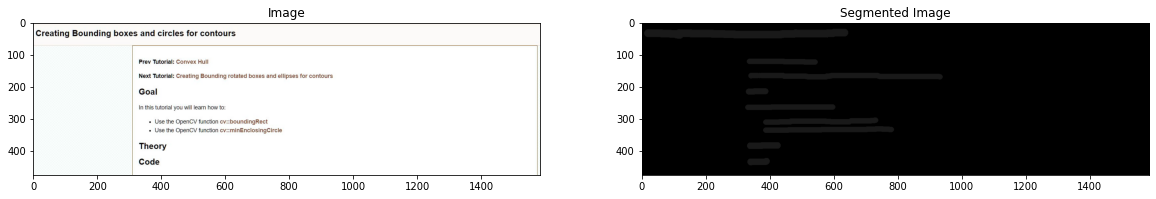

In [9]:
img = cv2.imread("/content/PageSegData/PageImg/" + str(image_list[0]) + ".JPG", 1)
seg = cv2.imread("/content/PageSegData/PageSeg/" + str(image_list[0]) + "_mask.png", 1)

visualize(img, seg)

### Neural network

In [10]:
def unet(pretrained_weights = None, input_size = (512, 512, 1)):
    inputs = Input(input_size)

    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

model = unet()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 512, 512, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_25 (Conv2D)             (None, 512, 512, 64  36928       ['conv2d_24[0][0]']              
                                )                                                           

### Train model

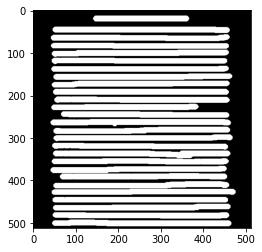

In [11]:
random.shuffle(image_list)
# mix data and divide into train and test groups
file_train = image_list[0:int(0.75 * len(image_list))]
file_test = image_list[int(0.75 * len(image_list)):]

img, seg = next(batch_generator(file_train, 2, 1))
plt.imshow(np.squeeze(seg[:,:,:,0],axis=0), cmap='gray')

In [12]:
mc = ModelCheckpoint('weights{epoch:08d}.h5', save_weights_only = True)
h = model.fit(batch_generator(file_train, 2, 2), epochs = 4, steps_per_epoch = 500, validation_data = batch_generator(file_test, 2, 2),
                    validation_steps = 400, callbacks = [mc], shuffle = 1, verbose = 1)

Epoch 1/4
500/500 [==============================] - 1131s 2s/step - loss: 0.2852 - accuracy: 0.9149 - val_loss: 0.1620 - val_accuracy: 0.9321
Epoch 2/4
500/500 [==============================] - 1102s 2s/step - loss: 0.1561 - accuracy: 0.9321 - val_loss: 0.1519 - val_accuracy: 0.9344
Epoch 3/4
500/500 [==============================] - 1102s 2s/step - loss: 0.1454 - accuracy: 0.9366 - val_loss: 0.1465 - val_accuracy: 0.9362
Epoch 4/4
500/500 [==============================] - 1103s 2s/step - loss: 0.1432 - accuracy: 0.9372 - val_loss: 0.1454 - val_accuracy: 0.9378


### LOSS

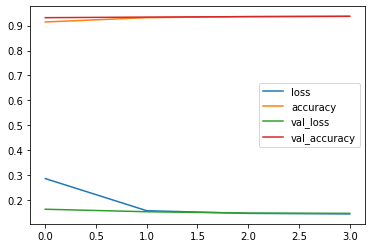

In [13]:
pd.DataFrame(h.history).plot()

In [3]:
img = cv2.imread(f"test_2.jpg", 0)
ret, img = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY_INV)
img = cv2.resize(img, (512, 512))
# img = np.expand_dims(img, axis =- 1)
img = np.expand_dims(img, axis = 0)
pred = model.predict(img)
pred = np.squeeze(np.squeeze(pred, axis = 0), axis =- 1)
plt.imshow(pred, cmap = 'gray')

NameError: name 'model' is not defined

### Save mask and crop found lines

In [28]:
plt.imsave("test_2_mask.jpg", pred)
coordinates=[]
img = cv2.imread("test_2_mask.jpg", 0) 
cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU, img)
ori_img = cv2.imread("test_2.jpg")
ori_img = cv2.resize(ori_img, (512,512))
contours, hier = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
s = 0
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    cropped = ori_img[y:y+h, x:x+w]
    plt.imsave(f"test_2_{s}.jpg", cropped)
    cv2.rectangle(ori_img, (x, y), (x + w, y + h), 255, 1)
    coordinates.append([x, y, (x + w), (y + h)])
    s += 1
    # cropped.save(f"/content/crop_jpg/test_1_{s}")
# print(coordinates)
# cv2.drawContours(img, contours, -1, (255, 255, 0), 1)

cv2.imwrite("output.jpg", ori_img)

True